# Evaluation of the Performances of a Change-Point Detection Method

In this notebook, we generate a piecewise constant times series in dimension $p$ and simulate the procedure defined in the paper [Optimal multiple change-point detection for high-dimensional data](https://arxiv.org/abs/1809.09602)

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objs as go
pio.renderers.default='notebook'
#sns.set()
import random
import numpy as np
from torch.nn.functional import conv1d
import plotly.express as px
from tqdm import tqdm
import time

import multichange as mc
from importlib import reload
reload(mc);

## Initialization

### For the bottom-up procedure

The class ChangePointDetector from module multichange instantiates the model for fixed $n$ and $p$. The procedure will compute Cusums for all $r \in \{1, 2, 4, 8, \dots \}$ and $l \in [r, n-r)$, rank the coordinates of each Cusum and compute partial norms with the $s$ largest coordinates with $s \in \{1, 2, 4, 8, \dots, \tfrac{\sqrt{p \gamma_r}}{\log(p) - \gamma_r}, p\}$ and $\gamma_r = \log(n/r\delta)$. $s = p$ corresponds to the statistic in the dense regime while smaller $s$ correspond to partial norm statistics.
Passing samples=1000, delta=0.05 as an argument means that we initialize the thresholds of the statistics for all $r$ and $s$ so that the maximum for $l \in [r, n-r)$ of all the partial norms at scale $r$ and sparsity $s$ is above the $(r,s)$-threshold on only $\delta = 0.05$ percent of the $1000$ samples. Here we only take $100$ samples so that it executes fast, but the experiments are made with $10.000$ samples.


In [4]:
p, n = 100, 200
torch.manual_seed(123456)
model = mc.ChangePointDetector(p=p, n=n, samples=100, delta=0.05)

### For the inspect procedure

To compare our method, we import the R package [inspect method](https://github.com/wangtengyao/InspectChangepoint/) with rpy2. To use this method, we compute the threshold with the monte carlo method provided by the function compute_threshold of the R package.

In [5]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import numpy as np 
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
insp = rpackages.importr('InspectChangepoint')

threshold_insp = insp.compute_threshold(n,p)

Calculating threshold... 

R[write to console]: Loading required namespace: RSpectra



101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100%. Threshold = 8.954897 


## Generating a Signal

`generate_wcs` is a function that generates a signal that is $0$ outside $[\tau_1, \tau_2)$ and $\Delta$ in $[\tau_1, \tau_2)$ of norm 'Norm' and which has exactly $s$ randomly chosen coordinates that have random sign.
In the cell bellow, we use `generate_K`, which generates $K$ change-points on random locations with random sparsities in $[1, p]$ and random norm in [MinNorm, MaxNorm]. 

In [6]:
torch.manual_seed(0)
np.random.seed(0)
reload(mc)
Signals, taustars = mc.generate_K(p, n, MinNorm=1, MaxNorm=10, K = 10, samples=1)
Noise = torch.randn((1, p, n))
Ys = Signals + Noise

Here, exactly 25 coordinates have two change points. The following block represents the first coordinate of the data and signal.

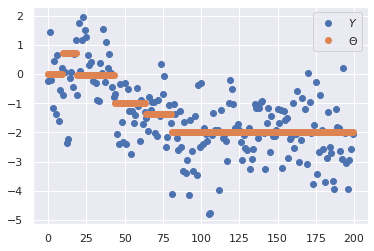

In [12]:
import matplotlib.image as mpimg
import pandas as pd
sns.set()
Y = Ys[0]
Signal = Signals[0]
i = 15
fig = go.Figure()
x = list(range(n))
df = pd.DataFrame({r'$Y$' : Y[i, :], r'$\Theta$' : Signal[i, :]})
df.plot(style=['o', 'o'])
plt.show();

## Fitting the Method to the Data

### For the bottom-up procedure

We use the .fit() method of the model to compute the Cusum statistics and apply the bottom up procedure defined in the paper. The corresponding function in the inspect package is the R function inspect. 
In this high-energy and dense change-points setting, both methods achieve a good detection of the change-points.

In [ ]:
model.fit(Ys)
taustars.sort()
print('Change-points detected at the following positions : tau = ', model.tau)
print('True change-points : taustars = ', taustars)
print('at following scales : r = ', model.scales)
print('and with statistics with following smallest sparsities : s = ', model.sparsities)

### For the Inspect Procedure

In [ ]:
try:
    tauinsp = insp.inspect(np.array(Ys[0]), threshold = threshold_insp)[1][:, 0]
except IndexError:
    tauinsp = []
print(tauinsp)

### Definition of the Loss

If $\{\tau_1, \dots, \tau_K \}$ are the true change-points and $\{\hat{\tau}_1, \dots, \hat {\tau}_{\hat{K}}\}$ the estimated change-points, We compare the two methods with the following quantity:
$$\tfrac{1}{K}\sum_k \left| |[(\tau_k + \tau_{k-1})/2,(\tau_k + \tau_{k+1})/2] \cap \{\hat \tau_k, k \in [\hat K]\}| - 1\right| \enspace ,$$
which is the ratio of all spurious change-points plus undetected true change-points over the number of true chagne-points.\
\
One simply checks that this quantity is large if either we estimate too many change-points or if we are too conservative and estimate only a few change-points. 

The following functions computes the quantity defined above.


In [ ]:
def compute_loss(taustars, taus, n):
    K = len(taustars)
    taustars = np.array([0] + taustars + [n])
    taus = np.array(taus)
    R = (taustars[1:] - taustars[:-1])/2
    numerator = 0
    for i in range(K):
        ndet = ((taustars[i+1] - R[i] <= taus) & (taus <= taustars[i+1] + R[i+1])).sum()
        numerator += np.abs(ndet - 1)
    return numerator/K

In [ ]:
print(f'loss of our method : {compute_loss(taustars, model.tau, n):.2f}')
print(f'loss of inspect method : {compute_loss(taustars, tauinsp, n):.2f}')

## Performances

Below are the experiences we talk about in [Optimal multiple change-point detection for high-dimensional data](https://hal.archives-ouvertes.fr/hal-03004860/). Here we set trials=50 so it takes less time to execute for the user.

In [ ]:
for s in [1, 20, p]:
    r = 20
    tau1 = n//3
    trials = 50
    taustars = [tau1, tau1 + r]
    loss = {'bottomup' : [], 'inspect' : []}
    loss_squared = {'bottomup' : [], 'inspect' : []}
    pdiff = {'bottomup' : [], 'inspect' : []}
    N = 100
    Norms = [0.5 + i*0.1 for i in range(N)]
    for i, norm in enumerate(Norms):
        print(f'Doing {trials} trials for step {i+1} / {len(Norms)}           ', end='\r')
        loss_0, loss_squared_0, pdiff_0 = 0, 0, 0
        loss_1, loss_squared_1, pdiff_1 = 0, 0, 0
        for j in range(trials):
            torch.manual_seed(j)
            Signals = mc.generate_wcs(p, n, s, Norm=norm, taus=(tau1, tau1+r))
            Noise = torch.randn((1, p, n))
            Ys = Signals + Noise
            model.fit(Ys)
            try:
                tauinsp = insp.inspect(np.array(Ys[0]), threshold = threshold_insp)[1][:,0]
            except IndexError:
                tauinsp = []
            if len(model.tau) != len(taustars):
                pdiff_0 += 1
            if len(tauinsp) != len(taustars):
                pdiff_1 +=1
            l_0 = compute_loss(taustars, model.tau, n)
            l_1 = compute_loss(taustars, tauinsp, n)
            loss_0 += l_0
            loss_1 += l_1
            loss_squared_0 += l_0**2
            loss_squared_1 += l_1**2
    
        pdiff['bottomup'].append(pdiff_0/trials)
        pdiff['inspect'].append(pdiff_1/trials)
        loss['bottomup'].append(loss_0/trials)
        loss['inspect'].append(loss_1/trials)
        loss_squared['bottomup'].append(loss_squared_0/trials)
        loss_squared['inspect'].append(loss_squared_1/trials)
    import pandas as pd
    
    pdiff["bottomup"] = pd.Series(pdiff["bottomup"], index=Norms)
    pdiff["inspect"] = pd.Series(pdiff["inspect"], index=Norms)
    loss["bottomup"] = pd.Series(loss["bottomup"], index=Norms)
    loss["inspect"] = pd.Series(loss["inspect"], index=Norms)
    df = pd.DataFrame(
        {
            "pdiff_bottomup": pdiff["bottomup"],
            "pdiff_inspect": pdiff["inspect"],
            "loss_bottomup": loss["bottomup"],
            "loss_inspect": loss["inspect"],
            "confidence_bound_bottomup": 1.96*((pdiff['bottomup'])*(1-pdiff['bottomup'])/trials)**(1/2),
            "confidence_bound_inspect": 1.96*((pdiff['inspect'])*(1-pdiff['inspect'])/trials)**(1/2),
            "sigma_loss_bottomup" : (loss_squared["bottomup"] - loss["bottomup"]**2)**(1/2),
            "sigma_loss_inspect" : (loss_squared["inspect"] - loss["inspect"]**2)**(1/2),
            "sigma_pdiff_bottomup" : (pdiff["bottomup"] - pdiff["bottomup"]**2)**(1/2),
            "sigma_pdiff_inspect" : (pdiff["inspect"] - pdiff["inspect"]**2)**(1/2)
        }
    )
    df.to_csv(f"./n{n}_p{p}_s{s}_r{r}_trials{trials}.csv")
    

In [ ]:
import pandas as pd

pdiff["bottomup"] = pd.Series(pdiff["bottomup"], index=Norms)
pdiff["inspect"] = pd.Series(pdiff["inspect"], index=Norms)
loss["bottomup"] = pd.Series(loss["bottomup"], index=Norms)
loss["inspect"] = pd.Series(loss["inspect"], index=Norms)
df = pd.DataFrame(
    {
        "pdiff_bottomup": pdiff["bottomup"],
        "pdiff_inspect": pdiff["inspect"],
        "loss_bottomup": loss["bottomup"],
        "loss_inspect": loss["inspect"],
        "confidence_bound_bottomup": 1.96*((pdiff['bottomup'])*(1-pdiff['bottomup'])/500)**(1/2),
        "confidence_bound_inspect": 1.96*((pdiff['inspect'])*(1-pdiff['inspect'])/500)**(1/2),
        "sigma_loss_bottomup" : (loss_squared["bottomup"] - loss["bottomup"]**2)**(1/2),
        "sigma_loss_inspect" : (loss_squared["inspect"] - loss["inspect"]**2)**(1/2),
        "sigma_pdiff_bottomup" : (pdiff["bottomup"] - pdiff["bottomup"]**2)**(1/2),
        "sigma_pdiff_inspect" : (pdiff["inspect"] - pdiff["inspect"]**2)**(1/2)
    }
)
df.to_csv(f"./n{n}_p{p}_s{s}_r{r}_trials{trials}.csv")

In [ ]:
reload(mc)
s = p
trials = 50
loss = {'bottomup' : [], 'inspect' : []}
loss_squared = {'bottomup' : [], 'inspect' : []}
pdiff = {'bottomup' : [], 'inspect' : []}
N = 200
Norms = [0.1 + i*0.05 for i in range(N)]
torch.manual_seed(0)
np.random.seed(0)
Signals, taustars = mc.generate_K(p, n, 1, 5, K=10)
print(taustars)
for i, norm in enumerate(Norms):
    print(f'Doing {trials} trials for step {i+1} / {len(Norms)}           ', end='\r')
    loss_0, loss_squared_0, pdiff_0 = 0, 0, 0
    loss_1, loss_squared_1, pdiff_1 = 0, 0, 0
    for j in range(trials):
        torch.manual_seed(j)
        Noise = torch.randn((1, p, n))
        Ys = norm*Signals + Noise
        model.fit(Ys)
        try:
            tauinsp = insp.inspect(np.array(Ys[0]), threshold = threshold_insp)[1][:,0]
        except IndexError:
            tauinsp = []
        if len(model.tau) != len(taustars):
            pdiff_0 += 1
        if len(tauinsp) != len(taustars):
            pdiff_1 +=1
        l_0 = compute_loss(taustars, model.tau, n)
        l_1 = compute_loss(taustars, tauinsp, n)
        loss_0 += l_0
        loss_1 += l_1
        loss_squared_0 += l_0**2
        loss_squared_1 += l_1**2

    pdiff['bottomup'].append(pdiff_0/trials)
    pdiff['inspect'].append(pdiff_1/trials)
    loss['bottomup'].append(loss_0/trials)
    loss['inspect'].append(loss_1/trials)
    loss_squared['bottomup'].append(loss_squared_0/trials)
    loss_squared['inspect'].append(loss_squared_1/trials)


In [ ]:
import pandas as pd

pdiff["bottomup"] = pd.Series(pdiff["bottomup"], index=Norms)
pdiff["inspect"] = pd.Series(pdiff["inspect"], index=Norms)
loss["bottomup"] = pd.Series(loss["bottomup"], index=Norms)
loss["inspect"] = pd.Series(loss["inspect"], index=Norms)
df = pd.DataFrame(
    {
        "pdiff_bottomup": pdiff["bottomup"],
        "pdiff_inspect": pdiff["inspect"],
        "loss_bottomup": loss["bottomup"],
        "loss_inspect": loss["inspect"],
        "confidence_bound_bottomup": 1.96*((pdiff['bottomup'])*(1-pdiff['bottomup'])/500)**(1/2),
        "confidence_bound_inspect": 1.96*((pdiff['inspect'])*(1-pdiff['inspect'])/500)**(1/2),
        "sigma_loss_bottomup" : (loss_squared["bottomup"] - loss["bottomup"]**2)**(1/2),
        "sigma_loss_inspect" : (loss_squared["inspect"] - loss["inspect"]**2)**(1/2),
        "sigma_pdiff_bottomup" : (pdiff["bottomup"] - pdiff["bottomup"]**2)**(1/2),
        "sigma_pdiff_inspect" : (pdiff["inspect"] - pdiff["inspect"]**2)**(1/2)
    }
)
df.to_csv(f"./K{10}_n{n}_p{p}_trials{trials}.csv")

## Running times

In [ ]:
import time
for s in [20]:
    r = 20
    tau1 = n//3
    trials = 500
    dt_insp=0
    dt_insp_sq=0
    dt_bottomup = 0
    dt_bottomup_sq = 0
    taustars = [tau1, tau1 + r]
    runtime = {'bottomup' : [], 'inspect' : []}
    N = 1
    Norms = [0 for i in range(N)]
    for i, norm in enumerate(Norms):
        print(f'Doing {trials} trials for step {i+1} / {len(Norms)}           ', end='\r')
        loss_0, loss_squared_0, pdiff_0 = 0, 0, 0
        loss_1, loss_squared_1, pdiff_1 = 0, 0, 0
        for j in range(trials):
            torch.manual_seed(j)
            Signals = mc.generate_wcs(p, n, s, Norm=norm, taus=(tau1, tau1+r))
            Noise = torch.randn((1, p, n))
            Ys = Signals + Noise

            t_bottomup = time.time()
            model.fit(Ys)
            dt_bottomup += time.time() - t_bottomup
            dt_bottomup_sq += (time.time() - t_bottomup)**2
            t_insp = time.time()
            try:
                tauinsp = insp.inspect(np.array(Ys[0]), threshold = threshold_insp)[1][:,0]
            except IndexError:
                tauinsp = []
            dt_insp += time.time() - t_insp
            dt_insp_sq += (time.time() - t_insp)**2


In [ ]:
dt_bottomup_sigma = np.sqrt(dt_bottomup_sq/trials - (dt_bottomup/trials)**2)/np.sqrt(500)
dt_insp_sigma = np.sqrt(dt_insp_sq/trials - (dt_insp/trials)**2)/np.sqrt(500)
print(f'bottomup : {dt_bottomup/trials} +- {dt_bottomup_sigma} ; inspect : {dt_insp/trials} +- {dt_insp_sigma}')

## Time dependent setting

In [ ]:
for s in [20]:
    r = 20
    rho = 0.05
    tau1 = n//3
    trials = 500
    taustars = [tau1, tau1 + r]
    loss = {'bottomup' : [], 'inspect' : []}
    loss_squared = {'bottomup' : [], 'inspect' : []}
    pdiff = {'bottomup' : [], 'inspect' : []}
    N = 100
    Norms = [0.5 + i*0.1 for i in range(N)]
    for i, norm in enumerate(Norms):
        print(f'Doing {trials} trials for step {i+1} / {len(Norms)}           ', end='\r')
        loss_0, loss_squared_0, pdiff_0 = 0, 0, 0
        loss_1, loss_squared_1, pdiff_1 = 0, 0, 0
        for j in range(trials):
            torch.manual_seed(j)
            Signals = mc.generate_wcs(p, n, s, Norm=norm, taus=(tau1, tau1+r))
            Noise = torch.randn((1, p, n))
            for t in range(1,n):
                Noise[0, :, t] = rho*Noise[0, :, t-1] + np.sqrt(1 - rho**2)*Noise[0, :, t]
            Ys = Signals + Noise
            model.fit(Ys)
            try:
                tauinsp = insp.inspect(np.array(Ys[0]), threshold = threshold_insp)[1][:,0]
            except IndexError:
                tauinsp = []
            if len(model.tau) != len(taustars):
                pdiff_0 += 1
            if len(tauinsp) != len(taustars):
                pdiff_1 +=1
            l_0 = compute_loss(taustars, model.tau, n)
            l_1 = compute_loss(taustars, tauinsp, n)
            loss_0 += l_0
            loss_1 += l_1
            loss_squared_0 += l_0**2
            loss_squared_1 += l_1**2
    
        pdiff['bottomup'].append(pdiff_0/trials)
        pdiff['inspect'].append(pdiff_1/trials)
        loss['bottomup'].append(loss_0/trials)
        loss['inspect'].append(loss_1/trials)
        loss_squared['bottomup'].append(loss_squared_0/trials)
        loss_squared['inspect'].append(loss_squared_1/trials)
    import pandas as pd
    
    pdiff["bottomup"] = pd.Series(pdiff["bottomup"], index=Norms)
    pdiff["inspect"] = pd.Series(pdiff["inspect"], index=Norms)
    loss["bottomup"] = pd.Series(loss["bottomup"], index=Norms)
    loss["inspect"] = pd.Series(loss["inspect"], index=Norms)
    df = pd.DataFrame(
        {
            "pdiff_bottomup": pdiff["bottomup"],
            "pdiff_inspect": pdiff["inspect"],
            "loss_bottomup": loss["bottomup"],
            "loss_inspect": loss["inspect"],
            "confidence_bound_bottomup": 1.96*((pdiff['bottomup'])*(1-pdiff['bottomup'])/500)**(1/2),
            "confidence_bound_inspect": 1.96*((pdiff['inspect'])*(1-pdiff['inspect'])/500)**(1/2),
            "sigma_loss_bottomup" : (loss_squared["bottomup"] - loss["bottomup"]**2)**(1/2),
            "sigma_loss_inspect" : (loss_squared["inspect"] - loss["inspect"]**2)**(1/2),
            "sigma_pdiff_bottomup" : (pdiff["bottomup"] - pdiff["bottomup"]**2)**(1/2),
            "sigma_pdiff_inspect" : (pdiff["inspect"] - pdiff["inspect"]**2)**(1/2)
        }
    )
    df.to_csv(f"./time_dependent_s{s}_rho{int(100*rho)}_trials{trials}.csv")
    